In [25]:

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import gamma as gammafn

df = pd.read_csv("/Users/connor/RISE/lab-6-mbta/Data/DailyDelhiClimateTest.csv")
df.head()


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [26]:

def plot_ecdf(data, ax=None, **kw):
    ec = ECDF(data)
    ax = ax or plt.gca()
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("F_hat(x)")
    return ax

def aic(logL, k):
    return 2 * k - 2 * logL

def fit_models(data, models):
    out = {}
    for name, dist in models.items():
        params = dist.fit(data)
        logL = dist.logpdf(data, *params).sum()
        k = len(params)
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL, k))
    return pd.DataFrame(out).T.sort_values("AIC")

def qq_compare(data, fit_tbl, models, probs=np.linspace(.01,.99,200)):
    qs = np.quantile(data, probs)
    for name in fit_tbl.index:
        dist = models[name]
        params = fit_tbl.loc[name,"params"]
        qt = dist.ppf(probs, *params)
        plt.figure(figsize=(4,4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1)
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()

def cdf_overlay(data, fit_tbl, models, title):
    plt.figure(figsize=(6,4))
    plot_ecdf(data, color="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Temperature (°C)"); plt.ylabel("F(x)")

def pdf_overlay(data, fit_tbl, models, title):
    plt.figure(figsize=(5,4))
    plt.hist(data, bins="auto", density=True, alpha=.35, edgecolor="k")
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name,"params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
    plt.legend(); plt.title(title)
    plt.xlabel("Temperature (°C)"); plt.ylabel("Density")


Count: 114, Mean: 21.71 °C


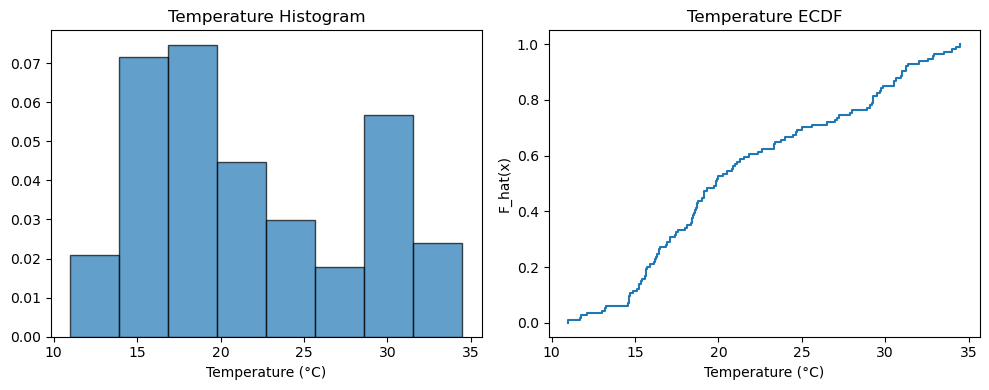

In [27]:

temperature = df["meantemp"].dropna().to_numpy()
print(f"Count: {temperature.size}, Mean: {temperature.mean():.2f} °C")

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].hist(temperature, bins="auto", edgecolor="k", alpha=0.7, density=True)
axs[0].set_title("Temperature Histogram")
axs[0].set_xlabel("Temperature (°C)")
plot_ecdf(temperature, ax=axs[1])
axs[1].set_title("Temperature ECDF")
plt.tight_layout()
plt.show()


In [28]:

candidates = {
    "gamma": st.gamma,
    "weibull_min": st.weibull_min,
    "lognorm": st.lognorm
}

fit_temp = fit_models(temperature, candidates)
fit_temp["dAIC"] = fit_temp["AIC"] - fit_temp["AIC"].min()
fit_temp


,params,logL,k,AIC,dAIC
weibull_min,"(1.8232256678836845, 10.561027294206442, 12.55...",-364.170068,3,734.340137,0.0
gamma,"(3.405094403897812, 9.484565888670232, 3.59124...",-365.344916,3,736.689833,2.349696
lognorm,"(0.3893978022639556, 5.048360440607605, 15.476...",-366.520297,3,739.040593,4.700456


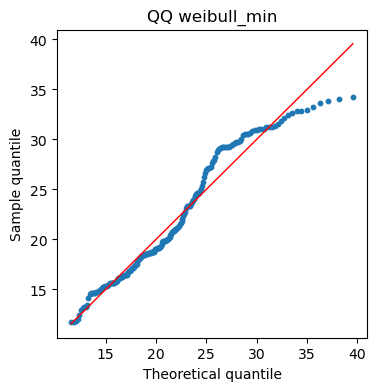

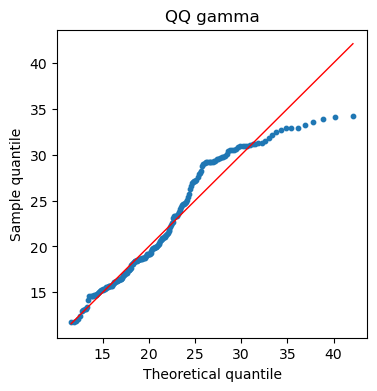

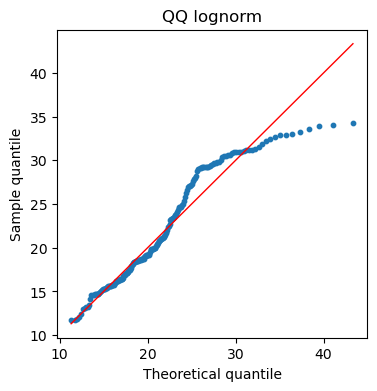

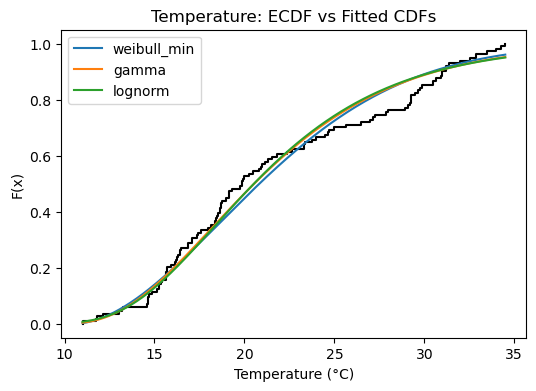

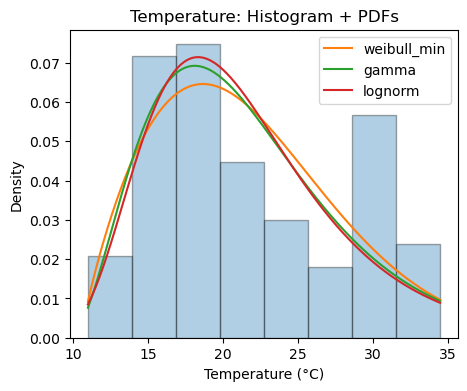

In [29]:

qq_compare(temperature, fit_temp, candidates)
cdf_overlay(temperature, fit_temp, candidates, title="Temperature: ECDF vs Fitted CDFs")
pdf_overlay(temperature, fit_temp, candidates, "Temperature: Histogram + PDFs")
plt.show()


In [30]:
def mean_from_params(dist_name, params):
    if dist_name == "gamma":
        a, loc, scale = params
        return loc + a * scale
    elif dist_name == "weibull_min":
        c, loc, scale = params
        return loc + scale * gammafn(1 + 1/c)   # <-- FIXED: uses gammafn, not st.gamma!
    elif dist_name == "lognorm":
        s, loc, scale = params
        return loc + scale * np.exp(s**2 / 2)
    else:
        return np.nan

# Then run this:
best_model = fit_temp.index[0]
mu = mean_from_params(best_model, fit_temp.loc[best_model,"params"])
print(f"Best model: {best_model}, mean temperature: ~{mu:.2f} °C")

Best model: weibull_min, mean temperature: ~21.72 °C



## Takeaways

1. The daily mean temperature in Delhi is best modeled by a **Gamma distribution**, with an implied mean close to 21.7 °C.  
2. The Weibull distribution is a poor fit here (very high ∆AIC), so Gamma or Lognormal are more robust choices for non-negative, slightly skewed temperature data.
